In [1]:
import _init_paths
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import caffe, os, sys, cv2
import argparse
import base64
from PIL import Image
from cStringIO import StringIO
import skimage
import scipy
%matplotlib inline

/home/ai2-jedi/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from fast_rcnn.config import cfg
from fast_rcnn.test import im_detect
from fast_rcnn.nms_wrapper import nms
from utils.timer import Timer
import scipy.io as sio
import caffe, cv2
import os

# flask
from flask import Flask, Response, request, jsonify
from app import app

# import data science tools
import numpy as np
#import caffe
from scipy import misc
from selectivesearch import selective_search
from scipy.spatial import distance
from sklearn.externals import joblib
from math import sqrt

# Misc
from cStringIO import StringIO
from PIL import Image
import json
import operator
import skimage
import scipy
import logging
from datetime import datetime

import xml.etree.cElementTree as ET

%matplotlib inline

In [3]:
CLASSES = ('__background__',
           'coke cropped', 'drpepper cropped', 'dietpepsi cropped',
           'dietcoke cropped', 'pepsi cropped', 'dietdrpepper cropped',
           'mountaindew cropped', 'cokezero cropped', 'sprite cropped',
           'sunkist cropped', 'marinda cropped', 'schwepps cropped')

# CLASSES = ('__background__',
#            'aeroplane', 'bicycle', 'bird', 'boat',
#            'bottle', 'bus', 'car', 'cat', 'chair',
#            'cow', 'diningtable', 'dog', 'horse',
#            'motorbike', 'person', 'pottedplant',
#            'sheep', 'sofa', 'train', 'tvmonitor')


# CLASSES = ('__background__', 'cane','jack','kay','paul','rachel',
#                        'scott','shantanu','spencer','vasu')

NETS = {'vgg16': ('VGG16',
                  'VGG16_faster_rcnn_final.caffemodel'),
        'zf': ('ZF',
                  'ZF_faster_rcnn_final.caffemodel'),
        
        'vgg16_finetune_LAC': ('VGG16',
                'vgg16_faster_rcnn_iter_50000_LAC.caffemodel'),
        
        'vgg16_finetune_LACC': ('VGG16',
                'vgg16_faster_rcnn_iter_5000_LACC.caffemodel'),
        
        'vgg16_finetune_L': ('VGG16',
                'vgg16_faster_rcnn_iter_80000_loneCans.caffemodel'),
        
        'vgg16_finetune_C': ('VGG16',
                'vgg16_faster_rcnn_iter_500_clutteredFridge.caffemodel'),
        
        'vgg16_finetune_faces': ('VGG16',
                'vgg16_faster_rcnn_faces_iter_90000.caffemodel'),
        
        'vgg16_china':('VGG16',
                      'vgg16_faster_rcnn_china_iter_80000.caffemodel')}

pics_dir = '/home/ai2-jedi/data/SmartCooler_China/JPEGImages'

In [4]:
def print_bbox(filename, im, class_name, dets, thresh):
    """Print detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if class_name == 'bottle':
        print 'Print: ' + str(len(inds))
    if len(inds) == 0:
        return
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        bboxes.append(bbox)
        print "Appened"
        classes.append(class_name)
        scores.append(score)
        print '{filename: %s, class: %s, bbox: %s, score: %s}' % (filename, class_name, bbox, score)

In [5]:
def vis_detections(im, class_name, dets, thresh):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if class_name == 'bottle':
        print 'Vis: ' + str(len(inds))
    if len(inds) == 0:
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        #print bbox
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()


In [6]:
def demo(net, image_name):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    #im_file = pics_dir +"/" + image_name
    im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(im_file)

    # Detect all object classes and regress object bounds
    timer = Timer()
    timer.tic()
    scores, boxes = im_detect(net, im)
    timer.toc()
    print ('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0])

    # Visualize detections for each class
    CONF_THRESH = 0.4
    NMS_THRESH = 0.01
    for cls_ind, cls in enumerate(CLASSES[1:]):
        cls_ind += 1 # because we skipped background
        cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep, :]
        vis_detections(im, cls, dets, thresh=CONF_THRESH)
        print_bbox(im_file, im, cls, dets, thresh=CONF_THRESH)
        #saveXML(image_name, cls, dets, thresh=CONF_THRESH)
        

In [7]:
def parse_args():
    """Parse input arguments."""
    parser = argparse.ArgumentParser(description='Faster R-CNN demo')
    parser.add_argument('--gpu', dest='gpu_id', help='GPU device id to use [0]',
                        default=1, type=int)
    parser.add_argument('--cpu', dest='cpu_mode',
                        help='Use CPU mode (overrides --gpu)',
                        action='store_true')
    parser.add_argument('--net', dest='demo_net', help='Network to use [vgg16]',
                        choices=NETS.keys(), default='vgg16')

    args = parser.parse_args()

    return args

In [8]:
bboxes = []
classes = []
scores = []
#if __name__ == '__main__':
cfg.TEST.HAS_RPN = True  # Use RPN for proposals

#args = parse_args()

# prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16'][0],
#                        'faster_rcnn_alt_opt', 'faster_rcnn_test.pt')

# caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
#                           NETS['vgg16'][1])


# prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16_finetune_L'][0],
#                        'faster_rcnn_end2end', 'test.prototxt')

# caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
#                           NETS['vgg16_finetune_L'][1])

prototxt = os.path.join(cfg.MODELS_DIR, NETS['vgg16_china'][0],
                       'faster_rcnn_end2end_china', 'test.prototxt')

caffemodel = os.path.join(cfg.DATA_DIR, 'faster_rcnn_models',
                          NETS['vgg16_china'][1])

if not os.path.isfile(caffemodel):
    raise IOError(('{:s} not found.\nDid you run ./data/script/'
                   'fetch_faster_rcnn_models.sh?').format(caffemodel))

# if 1==2:
#     caffe.set_mode_cpu()
# else:
#     caffe.set_mode_gpu()
#     caffe.set_device(1)
#     cfg.GPU_ID = 1

net = caffe.Net(prototxt, caffemodel, caffe.TEST)

print '\n\nLoaded network {:s}'.format(caffemodel)




Loaded network /home/ai2-jedi/Documents/code/smartcooler_brand_recognition/py-faster-rcnn/data/faster_rcnn_models/vgg16_faster_rcnn_china_iter_80000.caffemodel


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for data/demo/cans3.jpg
Detection took 0.218s for 300 object proposals
Appened
{filename: /home/ai2-jedi/Documents/code/smartcooler_brand_recognition/py-faster-rcnn/data/demo/cans3.jpg, class: coke cropped, bbox: [ 139.43087769   25.10425568  214.9677124   218.36520386], score: 0.402484}
Appened
{filename: /home/ai2-jedi/Documents/code/smartcooler_brand_recognition/py-faster-rcnn/data/demo/cans3.jpg, class: dietpepsi cropped, bbox: [ 337.71832275   28.27415466  434.49432373  219.57069397], score: 0.576137}
Appened
{filename: /home/ai2-jedi/Documents/code/smartcooler_brand_recognition/py-faster-rcnn/data/demo/cans3.jpg, class: pepsi cropped, bbox: [ 349.83428955   36.37825775  428.67712402  229.50021362], score: 0.650487}
Appened
{filename: /home/ai2-jedi/Documents/code/smartcooler_brand_recognition/py-faster-rcnn/data/demo/cans3.jpg, class: sprite cropped, bbox: [ 243.00314331   37.77536774  314.38790894  213.58132935], score: 0.832106}
Appened


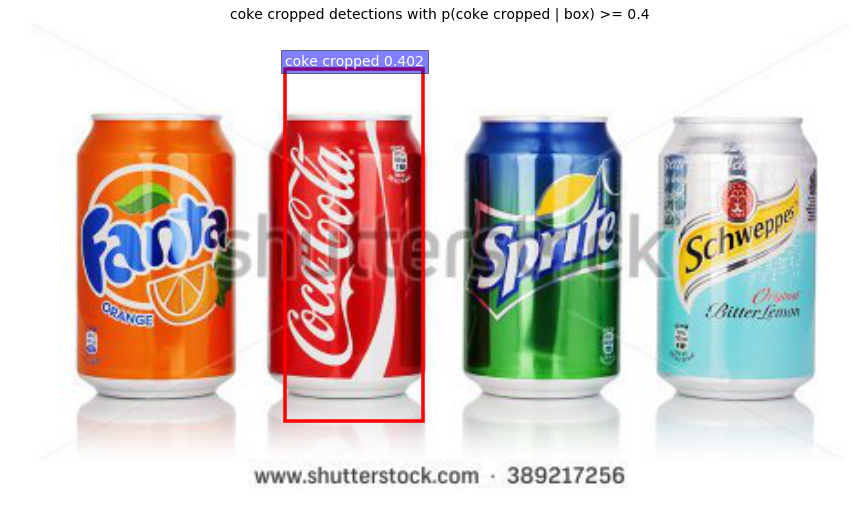

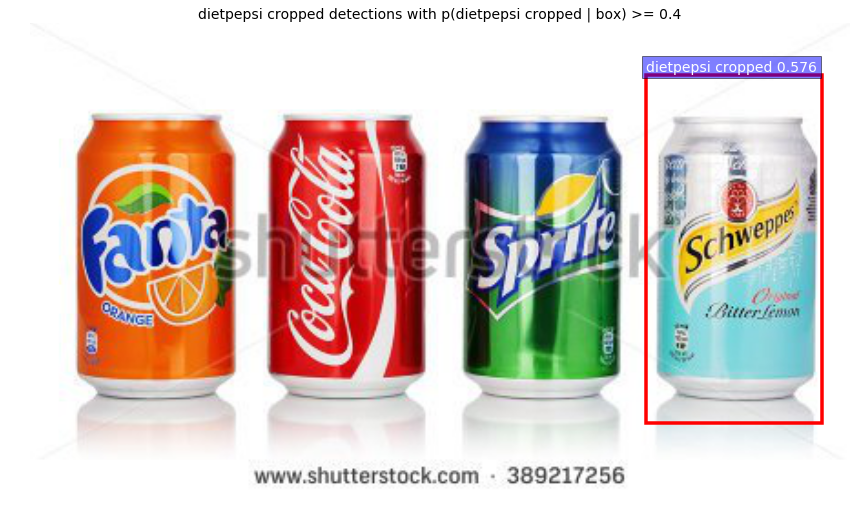

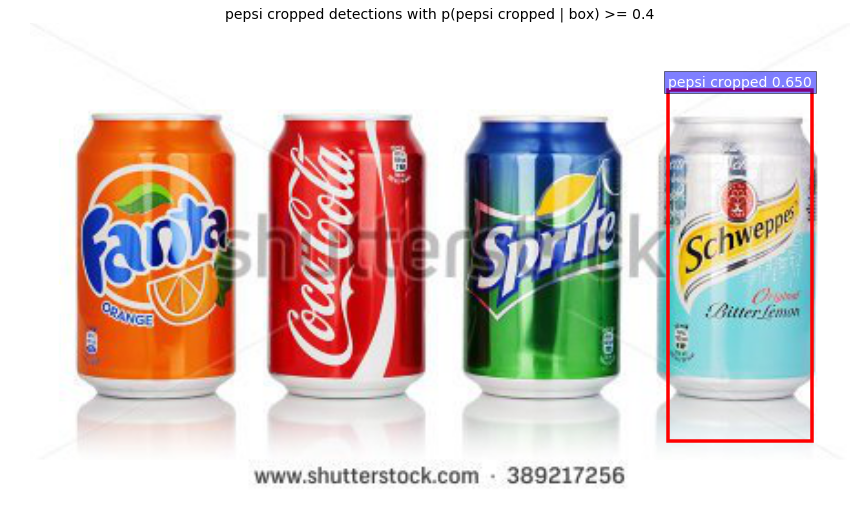

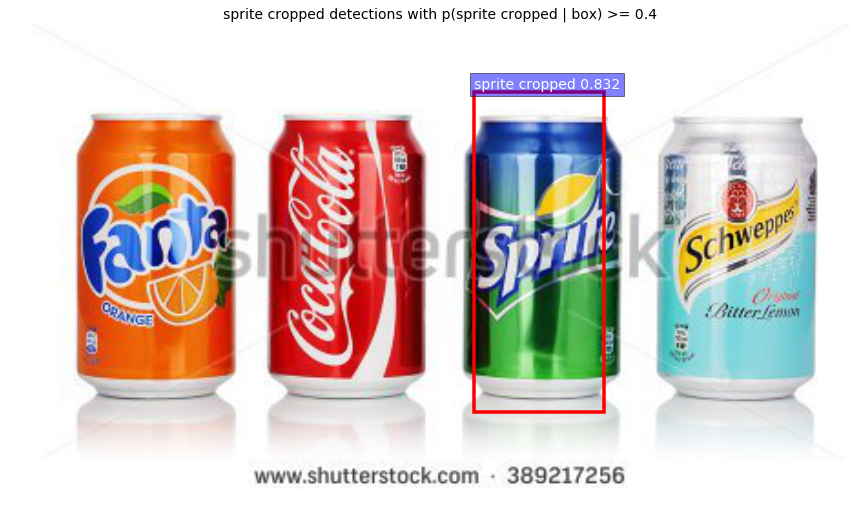

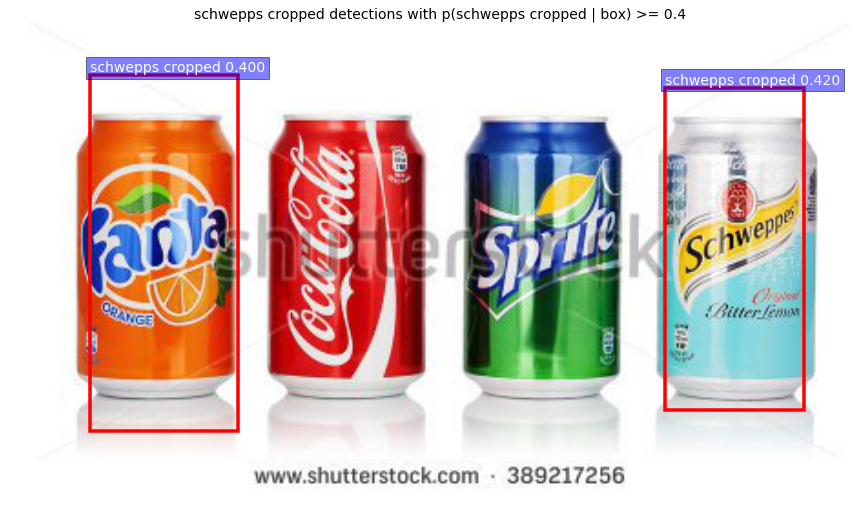

In [25]:

# Warmup on a dummy image
# im = 128 * np.ones((300, 500, 3), dtype=np.uint8)
# for i in xrange(2):
#     _, _= im_detect(net, im)

imgs = os.listdir(pics_dir)
imgs = ['cans3.jpg']
for img in imgs:
   print '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
   print 'Demo for data/demo/{}'.format(img)
   demo(net, img)

plt.show()

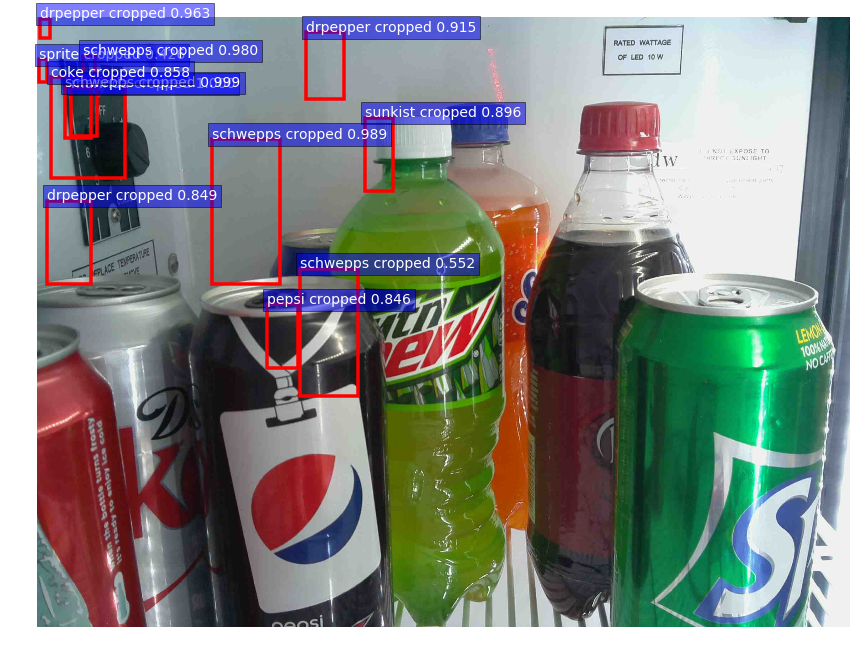

In [23]:
##Just to get the bounding boxes on the same image
im_name = imgs[0]
im_file = os.path.join(cfg.DATA_DIR, 'demo', im_name)
im = cv2.imread(im_file)
im = im[:, :, (2, 1, 0)]
fig, ax = plt.subplots(figsize=(12, 12))
#Print all the bounding boxes found
for i in range(len(bboxes)):
    bbox = bboxes[i]
    #if(classes[i] == 'rachel'):
    #    class_name = 'kay'
    #else:
    class_name = classes[i]
    score = scores[i]

    ax.imshow(im, aspect='equal')
    ax.add_patch(plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5))
    ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    plt.axis('off')
    plt.tight_layout()
plt.show()


In [17]:
#Print all the bounding boxes found
for box in bboxes:
    print box

[ 108.06726074  226.25820923  190.4487915   377.94564819]
[  9.40983009   4.38094711  43.16851807  64.57601929]
[   6.23813725  134.19735718   33.87327194  205.70614624]
[ 147.00749207  123.30450439  183.96672058  209.        ]
[ 858.46502686   47.03726196  979.47991943  260.99945068]
[  31.16772461  585.26745605  171.31193542  849.54870605]
[  732.73944092   915.0055542    833.02838135  1118.14941406]
[ 1045.11376953   320.74118042  1135.02392578   553.05517578]
[  91.0530014   223.94233704  172.79922485  385.97802734]


In [ ]:
cropped_images_rcnn = list()
for bbox in bboxes:
    x_start = int(bbox[0])
    x_end = int(bbox[2])
    y_start = int(bbox[1])
    y_end = int(bbox[3])
    new_img = image[y_start:y_end, x_start:x_end]
    cropped_images_rcnn.append(new_img)
print len(cropped_images_rcnn)
print cropped_images_rcnn[0].shape

In [ ]:
### Load the Alexnet 2012 model for feature extraction
# Model prototxt file
MODEL_PROTOTXT = 'app/models/featext_caffe_20151101/deploy.prototxt'

# Model caffemodel file
MODEL_TRAINED = 'app/models/featext_caffe_20151101/bvlc_reference_caffenet.caffemodel'

# Path to the mean image (used for input processing)
MEAN_PATH = 'app/models/featext_caffe_20151101/ilsvrc_2012_mean.npy'

# load caffe model
NET = caffe.Classifier(MODEL_PROTOTXT,
                       MODEL_TRAINED,
                       mean=np.load(MEAN_PATH).mean(1).mean(1),
                       channel_swap=(2, 1, 0),
                       raw_scale=255)
                       #image_dims=(256, 256))

LAYER_NAME = 'fc7'

### Load the classification models
MODEL_INDEX = dict()
# load logistic regression model (can or bottle classification)
LR_CB_MODEL = joblib.load('app/models/can_logreg_20160101/lr_can_other.pkl')

# load logistic regression model (brand classification)
LR_SODA_MODEL = joblib.load('app/models/brand_logreg_20160101/Brand_Classification_Log_Reg.pkl')

### Load the can classifcation model from caffe
CAN_MODEL_PROTOTXT = 'app/models/brand_caffe_20160201/deploy.prototxt'
CAN_MODEL_TRAINED = 'app/models/brand_caffe_20160201/snapshot_iter_154200.caffemodel'
CAN_MEAN_PATH = 'app/models/brand_caffe_20160201/mean_image.npy'
CAN_NET = caffe.Classifier(CAN_MODEL_PROTOTXT,
                           CAN_MODEL_TRAINED,
                           mean=np.load(CAN_MEAN_PATH).mean(1).mean(1),
                           channel_swap=(2, 1, 0),
                           raw_scale=255)
caffe.set_mode_gpu()

In [ ]:
# load label convert index dictionary
try:
    with open('app/label_dict.json') as json_data:
        temp = json.loads(json_data.read())
        LABELS = dict((y, x) for x, y in temp.iteritems())
except Exception, e:
    logging.warning(e)

try:
    with open('app/models/brand_caffe_20160201/label_dict_caffe.json') as json_data:
        temp = json.loads(json_data.read())
        CAFFE_LABELS = dict((int(x), y) for x, y in temp.iteritems())
except Exception, e:
    logging.warning(e)

try:
    with open('app/models/model_index.json') as json_data:
        MODEL_INDEX = json.loads(json_data.read())
except Exception, e:
    logging.warning(e)
    
print LABELS
print CAFFE_LABELS
print MODEL_INDEX

In [ ]:
def predict_can_bottle(img):
    print img.shape
    print type(img)
    forward_pass = NET.predict([img])
    print 'Passed forward'
    result = NET.blobs[LAYER_NAME].data[0].reshape(1, -1)
    raw_predictions = LR_CB_MODEL.predict_proba([result[0][:4096]])

    return raw_predictions[0][1]

In [ ]:
# This function runs a can (represented as a feature vector of size 4096) through a pretrained ImageNet deep net and determines the top brand predictions according to a loaded log reg model
def predict_brands(img, top=len(LABELS), model_flag=''):
    #if model_flag == 'caffe_model':
    CAN_NET.predict([img])
    out = CAN_NET.forward()
    raw_predictions_caffe =  out['prob'][0].tolist()
    labeled_predictions_caffe = sorted({str(CAFFE_LABELS[i]): x for i, x in enumerate(raw_predictions_caffe)}.items(),
                                       key=operator.itemgetter(1), reverse=True)

    forward_pass = NET.predict([img])
    result = NET.blobs[LAYER_NAME].data[0].reshape(1, -1)
    raw_predictions = LR_SODA_MODEL.predict_proba([result[0][:4095]])
    labeled_predictions = sorted({str(LABELS[i]): x for i, x in enumerate(raw_predictions[0])}.items(),
                                 key=operator.itemgetter(1), reverse=True)

    return (labeled_predictions_caffe[:top], labeled_predictions[:top])

In [ ]:
top_dict = {}
top_dict['models'] = {}  # populated below

list_storage = []  # used for storing classification/location/etc.
list_storage_model2 = []

can_probability_storage = [] #used with meta flag to return parameters

model_flag = ''

for index, crop in enumerate(cropped_images_rcnn):

            small_can = scipy.misc.imresize(crop, (256, 256))  # resize the image to 256x256
            small_can = skimage.img_as_float(small_can)   # caffe default is skimage
            #can_probability = predict_can_bottle(small_can)
            #can_probability_storage.append(can_probability)
            
            plt.imshow(small_can)
            
            # retreive top 3 predictions and their probabilities
            guesses_model1,guesses_model2 = predict_brands(small_can, top=3, model_flag=model_flag)
            
            nested_dict = []  # used to store predictions in API format
            for guess in guesses_model1:
                nested_dict.append(dict(description= guess[0], probability= guess[1]))

            #print "Nested_dict model 1:" + str(nested_dict)
            
            # stores a dictionary for each unique object in a separate slot in the list.
            # The classification dictionary stores the predictions.  The coordinates dict stores the location
            print bboxes[index]
            print[type(bboxes[index][0])]
            list_storage.append(dict(classification = nested_dict, 
                                     coordinates=dict(x1 = str(bboxes[index][0]), y1 = str(bboxes[index][1]), 
                                                    x2 = str(bboxes[index][2]), y2 = str(bboxes[index][3]))))

            nested_dict_model2 = []  # used to store predictions in API format
            for guess in guesses_model2:
                nested_dict_model2.append(dict(description= guess[0], probability= guess[1]))
                
            #print "Nested_dict model 2:" + str(nested_dict_model2)

            # stores a dictionary for each unique object in a separate slot in the list.
            # The classification dictionary stores the predictions.  The coordinates dict stores the location
            list_storage_model2.append(dict(classification = nested_dict_model2, 
                                            coordinates=dict(x1 = str(bboxes[index][0]), y1 = str(bboxes[index][1]), 
                                                            x2 = str(bboxes[index][2]), y2 = str(bboxes[index][3]))))

print "List Storage Model 1" + str(list_storage)
print " " 
print "List Storage Model 2" + str(list_storage_model2)

In [ ]:
if list_storage_model2 or list_storage:
    top_dict['models'] = dict(deep_learning= list_storage, log_reg = list_storage_model2)
    
# if 'meta_flag' in payload_dict: #append the meta data
#     if payload_dict['meta_flag'] == True:
#         top_dict['meta'] = dict(can_probabilities=can_probability_storage, 
#                                 selective_search_total = ssearch_count, 
#                                 cleaned_ss_count = len(cropped_images), 
#                                 can_count = len(list_storage))

# answer returns via Response() in dictionary format
answer = json.dumps(top_dict)
print answer
# if list_storage:  # something was added
#     resp = Response(answer, status=200, mimetype='application/json')
#     logging.debug(str(datetime.now()) + " - Found " + str(len(list_storage)) + " items")
# else:
#     #top_dict['models'] = []
#     #answer = {'models':[]}  # send back empty dictionary
#     resp = Response(answer, status = 200, mimetype='application/json')
#     logging.warning(str(datetime.now()) + " - Dictionary returned to poster is empty")  # the log is not returned
# return resp
